In this example we run through a simplified procedure to calculate the inter-molecular electronic coupling energies between penta-3-hexylthiophene

Procedure:
    * Generate models of thiophene and hexane based on based on quantum chemistry data from NWChem
    * Use streamm to create a 3-hexylthiophene pentamer
    * Replicate the pentamer into a periodic simulation cell
    * Anneal the system with LAMMPS
    * Calculate the inter-molecular electronic coupling using NWChem's electron transfer module 

In [1]:
import os 
from pprint import pprint

In [2]:
from pathlib2 import Path
import os

In [3]:
import csv 

In [4]:
import numpy as np
import decimal
import copy

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline

In [7]:
import time

Set wait time to check if calculation has finished

In [8]:
status_refresh = 1

In [9]:
import streamm

In this getting started example we will calculate the coupling between P3HT oligomers

In [10]:
import logging
logging.basicConfig(filename='p3ht_et.log',level=logging.DEBUG)

Load Resource objects from Resource example

In [11]:
need_files = ['local_res.json','remote_res.json']
for f in need_files:
    path = Path(f)
    if not path.is_file():
        print("Need to run resource_example.ipynb")
        os.system("jupyter nbconvert --to python  resource_example.ipynb")
        os.system("python resource_example.py")

In [12]:
res_local = streamm.Resource('local')

The calc resource can be changed to local or remote host resouce 

In [13]:
res_calc = streamm.Resource('remote')

In [14]:
res_local.import_json()
res_calc.import_json()

Create needed directories 

In [15]:
res_local.make_dir() 
res_calc.make_dir() 

Now let's create project and resource to keep track of our work

In [16]:
p3ht_et = streamm.Project('P3HT_ET')

Set the directory structure for the project 

In [17]:
p3ht_et.set_resource(res_local)

Explicitely create a thiophene molecule

In [18]:
bbTh = streamm.Buildingblock('thiophene')
symbols = ['C','C','C','C','S','H','H','H','H']
positions = [ ]
positions.append([-1.55498576,-1.91131218,-0.00081000])
positions.append([-0.17775976,-1.91131218,-0.00081000])
positions.append([0.34761524,-0.57904218,-0.00081000])
positions.append([-0.65884476,0.36101082,0.00000000])
positions.append([-2.16948076,-0.35614618,-0.00000800])
positions.append([-2.18966076,-2.79526518,-0.00132100])
positions.append([0.45389024,-2.80145418,-0.00106400])
positions.append([1.41682424,-0.35961818,-0.00138200])
positions.append([-0.51943676,1.44024682,0.00064700])
for i in range(len(symbols)):
    pt_i = streamm.Particle(symbol=symbols[i])
    pos_i = positions[i]
    bbTh.add_partpos(pt_i,pos_i)

Set the names of the terminal sites to be joined later

In [19]:
bbTh.particles[5].rsite = 'termcap'
bbTh.particles[6].rsite = 'funccap'
bbTh.particles[8].rsite = 'termcap'

Set some properties of the molecule to keep track of the parts

In [20]:
c_cnt =1
h_cnt =1

for pkey_i, particle_i  in bbTh.particles.iteritems():

    if( particle_i.symbol == 'C' ):
        particle_i.label = "C%d"%(c_cnt)
        particle_i.resname = "SCP2"
        particle_i.residue = 1

        c_cnt +=1 
    if( particle_i.symbol == 'S' ):
        particle_i.resname = "ThS"
        particle_i.residue = 2

    if( particle_i.symbol == 'H' ):
        particle_i.label = "H%d"%(h_cnt)
        particle_i.resname = "HA"
        particle_i.residue = 3

        h_cnt +=1 


Set the force-field type and guess some reasonable charges 

In [21]:
for pkey_i, particle_i  in bbTh.particles.iteritems():
    if( particle_i.symbol == 'C' ):
        particle_i.paramkey = 'CA'
        particle_i.charge = -0.025
    if( particle_i.symbol == 'S' ):
        particle_i.paramkey = 'S'
        particle_i.charge = -0.3
    if( particle_i.symbol == 'H' ):
        particle_i.paramkey = 'HA'
        particle_i.charge = 0.1

Check molecule is neutral 

In [22]:
total_charge = 0.0
for pkey_i, particle_i  in bbTh.particles.iteritems():
    total_charge += particle_i.charge
print total_charge

-2.77555756156e-17


Optimize structure with NWChem

But let's put it in a function this time

In [23]:
def nw_opt(project_i,bb_i,res_i):
    '''Optimize a streamm Buildingblock object with nwchem 
    
    '''
    calc_n =  len(project_i.calculations)     
    nwchem_i = streamm.NWChem('nw_opt_{}_calc_{}'.format(bb_i.tag,calc_n))
    print nwchem_i.tag 
    # Add thiophene structure 
    nwchem_i.strucC = copy.deepcopy(bb_i)
    # Set calculation to run on external resource
    nwchem_i.set_resource(res_i)
    # Make the local directories 
    nwchem_i.make_dir()
    #Change to the `launch` directory
    os.chdir(nwchem_i.dir['launch'])
    # Copy over templates
    nwchem_i.cp_file('templates','run',"nwchem_remote.pbs",'templates','launch')
    nwchem_i.cp_file('templates','nw',"nwchem.nw",'templates','launch')
    # Read in templates files 
    nwchem_i.load_str('templates','nw')        
    nwchem_i.load_str('templates','run')
    # Set calculation properties 
    nwchem_i.properties['basis'] = '6-31g'
    nwchem_i.properties['method'] = 'UHF'
    nwchem_i.properties['charge'] = 0
    nwchem_i.properties['spin_mult'] = 1
    nwchem_i.properties['task'] = 'SCF optimize'
    nwchem_i.properties['coord'] = nwchem_i.strucC.write_coord()
    # 
    pprint(nwchem_i.properties)
    # Replace <key> with properties value 
    nwchem_i.replacewrite_prop('nw','input','nw','%s.nw'%(nwchem_i.tag))
    nwchem_i.properties['input_nw'] = nwchem_i.files['input']['nw']
    nwchem_i.replacewrite_prop('run','scripts','run','%s.pbs'%(nwchem_i.tag))
    #
    nwchem_i.add_file('output','log',"%s.log"%(nwchem_i.tag))
    # Save details in .json files 
    os.chdir(nwchem_i.dir['home'])
    p3ht_et.export_json()
    # 
    os.chdir(nwchem_i.dir['launch'])
    # 
    nwchem_i.push()
    # 
    nwchem_i.run()
    # Add calculation to project
    project_i.add_calc(nwchem_i,deepcopy = True)
    # 
    return project_i 

In [24]:
p3ht_et = nw_opt(p3ht_et,bbTh,res_calc)

nw_opt_thiophene_calc_0
{u'allocation': u'',
 u'basis': '6-31g',
 u'charge': 0,
 'comp_key': 'compressed',
 'compress': 'tar -czf ',
 'compress_sufix': 'tgz',
 'coord': u'     C      -1.55498576      -1.91131218      -0.00081000 \n     C      -0.17775976      -1.91131218      -0.00081000 \n     C       0.34761524      -0.57904218      -0.00081000 \n     C      -0.65884476       0.36101082       0.00000000 \n     S      -2.16948076      -0.35614618      -0.00000800 \n     H      -2.18966076      -2.79526518      -0.00132100 \n     H       0.45389024      -2.80145418      -0.00106400 \n     H       1.41682424      -0.35961818      -0.00138200 \n     H      -0.51943676       1.44024682       0.00064700 \n',
 u'exe_command': u'./',
 u'feature': u'24core',
 u'finish_str': u'Total times  cpu:',
 u'maxiter': 100,
 u'method': 'UHF',
 u'nodes': 1,
 u'nproc': 1,
 u'pmem': 1500,
 u'ppn': 1,
 u'queue': u'batch',
 'scratch': u'/scratch/my_username/nw_opt_thiophene_calc_0/',
 u'spin_mult': 1,
 u'tas

In [25]:
nwchem_i = p3ht_et.calculations['nw_opt_thiophene_calc_0']

Check status unit finished

In [26]:
while( nwchem_i.meta['status'] != 'finished'):
    nwchem_i.check()
    time.sleep(status_refresh)    

In [27]:
print nwchem_i.meta['status']

finished


In [ ]:
os.chdir(nwchem_i.dir['launch'])

In [28]:
nwchem_i.analysis()

Running analysis on  nw_opt_thiophene_calc_0.log


Print energies, just for fun

In [29]:
print nwchem_i.properties['energy'],nwchem_i.unit_conf['energy']

-551.190757873 Ha


Check that the positions of the structure have been optimized 

In [30]:
print bbTh.positions

[[ -1.55498576e+00  -1.91131218e+00  -8.10000000e-04]
 [ -1.77759760e-01  -1.91131218e+00  -8.10000000e-04]
 [  3.47615240e-01  -5.79042180e-01  -8.10000000e-04]
 [ -6.58844760e-01   3.61010820e-01   0.00000000e+00]
 [ -2.16948076e+00  -3.56146180e-01  -8.00000000e-06]
 [ -2.18966076e+00  -2.79526518e+00  -1.32100000e-03]
 [  4.53890240e-01  -2.80145418e+00  -1.06400000e-03]
 [  1.41682424e+00  -3.59618180e-01  -1.38200000e-03]
 [ -5.19436760e-01   1.44024682e+00   6.47000000e-04]]


In [31]:
bbTh.unit_conf['length']

u'ang'

In [32]:
print nwchem_i.strucC.positions

[[ -1.52907004e+00  -1.96233843e+00  -1.23341000e-03]
 [ -1.87273370e-01  -1.91412987e+00  -1.73523000e-03]
 [  3.42609150e-01  -5.70398020e-01  -1.25113000e-03]
 [ -6.05157220e-01   3.80544790e-01  -3.32630000e-04]
 [ -2.25060124e+00  -3.24219650e-01  -2.63810000e-04]
 [ -2.16239570e+00  -2.82036259e+00  -8.80000000e-05]
 [  4.31314900e-01  -2.78795308e+00  -1.22182000e-03]
 [  1.39124929e+00  -3.53851760e-01  -4.46300000e-04]
 [ -4.82514600e-01   1.43981597e+00   1.01435000e-03]]


In [33]:
nwchem_i.strucC.unit_conf['length']

u'ang'

Update positions with optimized geometry 

In [34]:
for pk,p in bbTh.particles.iteritems():
    bbTh.positions[pk] = nwchem_i.strucC.positions[pk]
    print pk,p.symbol,bbTh.positions[pk]

0 C [ -1.52907004e+00  -1.96233843e+00  -1.23341000e-03]
1 C [ -1.87273370e-01  -1.91412987e+00  -1.73523000e-03]
2 C [ 0.34260915 -0.57039802 -0.00125113]
3 C [ -6.05157220e-01   3.80544790e-01  -3.32630000e-04]
4 S [ -2.25060124e+00  -3.24219650e-01  -2.63810000e-04]
5 H [ -2.16239570e+00  -2.82036259e+00  -8.80000000e-05]
6 H [  4.31314900e-01  -2.78795308e+00  -1.22182000e-03]
7 H [  1.39124929e+00  -3.53851760e-01  -4.46300000e-04]
8 H [ -4.82514600e-01   1.43981597e+00   1.01435000e-03]


Store the results in a tar ball in the storage directory 

In [35]:
nwchem_i.store()

Now let us calculate the ESP charges to use in our forcefield 

Again let's make it a function

In [36]:
def nw_esp(project_i,bb_i,res_i):
    '''Calculate ESP charges of a streamm Buildingblock object with nwchem 
    
    '''
    calc_n =  len(project_i.calculations)     
    nwchem_esp = streamm.NWChem('nw_esp_{}_calc_{}'.format(bb_i.tag,calc_n))
    print(nwchem_esp.tag)
    # Add thiophene structure with optimized coordinates from previous calculation
    nwchem_esp.strucC = copy.deepcopy(bb_i)
    # Set calculation to run on external resource
    nwchem_esp.set_resource(res_i)
    # Add calculation to project
    project_i.add_calc(nwchem_esp)
    # Make the local directories 
    nwchem_esp.make_dir()
    # Change to the `launch` directory
    os.chdir(nwchem_esp.dir['launch'])
    #
    nwchem_esp.cp_file('templates','run',"nwchem_remote.pbs",'templates','launch')
    nwchem_esp.cp_file('templates','nw',"nwchem_esp.nw",'templates','launch')
    #
    nwchem_esp.load_str('templates','nw')        
    nwchem_esp.load_str('templates','run')
    # 
    nwchem_esp.properties['basis'] = '6-31g'
    nwchem_esp.properties['method'] = 'UHF'
    nwchem_esp.properties['charge'] = 0
    nwchem_esp.properties['spin_mult'] = 1
    nwchem_esp.properties['task'] = 'SCF'
    nwchem_esp.properties['coord'] = nwchem_esp.strucC.write_coord()

    pprint(nwchem_esp.properties)

    nwchem_esp.replacewrite_prop('nw','input','nw','%s.nw'%(nwchem_esp.tag))

    nwchem_esp.properties['input_nw'] = nwchem_esp.files['input']['nw']
    nwchem_esp.replacewrite_prop('run','scripts','run','%s.pbs'%(nwchem_esp.tag))

    nwchem_esp.add_file('output','log',"%s.log"%(nwchem_esp.tag))

    # Save details in .json files 

    os.chdir(nwchem_esp.dir['home'])
    nwchem_esp.export_json()

    os.chdir(nwchem_esp.dir['launch'])
    nwchem_esp.push()
    nwchem_esp.run()
    # Add calculation to project
    project_i.add_calc(nwchem_esp,deepcopy = True)
    # 
    return project_i 
    
    

In [37]:
p3ht_et = nw_esp(p3ht_et,bbTh,res_calc)

nw_esp_thiophene_calc_1
{u'allocation': u'',
 u'basis': '6-31g',
 u'charge': 0,
 'comp_key': 'compressed',
 'compress': 'tar -czf ',
 'compress_sufix': 'tgz',
 'coord': u'     C      -1.52907004      -1.96233843      -0.00123341 \n     C      -0.18727337      -1.91412987      -0.00173523 \n     C       0.34260915      -0.57039802      -0.00125113 \n     C      -0.60515722       0.38054479      -0.00033263 \n     S      -2.25060124      -0.32421965      -0.00026381 \n     H      -2.16239570      -2.82036259      -0.00008800 \n     H       0.43131490      -2.78795308      -0.00122182 \n     H       1.39124929      -0.35385176      -0.00044630 \n     H      -0.48251460       1.43981597       0.00101435 \n',
 u'exe_command': u'./',
 u'feature': u'24core',
 u'finish_str': u'Total times  cpu:',
 u'maxiter': 100,
 u'method': 'UHF',
 u'nodes': 1,
 u'nproc': 1,
 u'pmem': 1500,
 u'ppn': 1,
 u'queue': u'batch',
 'scratch': u'/scratch/my_username/nw_esp_thiophene_calc_1/',
 u'spin_mult': 1,
 u'tas

Check status until finished

In [40]:
p3ht_et.check()

Calculation nw_esp_thiophene_calc_1 has status finished
Calculation nw_opt_thiophene_calc_0 has status stored


In [38]:
nwchem_i = p3ht_et.calculations['nw_esp_thiophene_calc_1']

In [ ]:
os.chdir(nwchem_i.dir['launch'])

In [39]:
while( nwchem_i.meta['status'] != 'finished'):
    nwchem_i.check()
    time.sleep(status_refresh)    

Run analysis to get the ESP charges

In [41]:
nwchem_i.analysis()

Running analysis on  nw_esp_thiophene_calc_1.log


Check the new charges 

In [42]:
nwchem_i.strucC.calc_charge()
print nwchem_i.strucC.charge

0.0


A little extra charge can cause problems with our MD simulation so, if our total is not zero let's round and set to neutral 

In [43]:
def charges_round_neutral(strucC,ndigits = 4  ):
    total_charge = 0.0 
    for pk,p in strucC.particles.iteritems():
        p.charge = round(p.charge,ndigits)
        total_charge += p.charge
    #
    print total_charge
    #
    for pk,p in strucC.particles.iteritems():
        p.charge += -1.0*total_charge/strucC.n_particles 
    strucC.calc_charge()
    #
    print strucC.charge

In [44]:
if( abs(nwchem_i.strucC.charge) > 1.0e-16 ):
    charges_round_neutral(nwchem_i.strucC)

Update the charges of the Buildingblock

In [45]:
bbTh.tag += '_HFesp'

In [46]:
print bbTh.tag

thiophene_HFesp


In [47]:
for pk,p in bbTh.particles.iteritems():
    p.charge = nwchem_i.strucC.particles[pk].charge
    print pk,p.symbol,p.charge

0 C -0.085722
1 C -0.136866
2 C -0.085772
3 C -0.108841
4 S -0.11776
5 H 0.153759
6 H 0.119036
7 H 0.109131
8 H 0.153035


Store the results 

In [48]:
nwchem_i.store()

Create the neighbor list and use it to set the bonds, bond angles and dihedrals for the force-field model

In [49]:
bbTh.bonded_nblist = bbTh.guess_nblist(0,radii_buffer=1.35)

In [50]:
bbTh.bonded_bonds()
bbTh.bonded_angles()
bbTh.bonded_dih()

Store a object of the Buildingblock

In [51]:
os.chdir(res_local.dir['materials']) 
th_json = bbTh.export_json()

Let us optimize the structure with the oplsaa force-field to check the parameters 

In [52]:
os.chdir(res_local.dir['home']) 

In [1]:
need_files = ['oplsaa_param.json']
for f in need_files:
    path = Path(f)
    if not path.is_file():
        print("Need to run forcefields_example.ipynb")
        os.system("jupyter nbconvert --to python  forcefields_example.ipynb")
        os.system("python forcefields_example.py")

NameError: name 'Path' is not defined

In [54]:
oplsaa = streamm.Parameters('oplsaa')

In [55]:
oplsaa.import_json(read_file=True)

In [56]:
print oplsaa


    Parameters 
      LJ parameters 2 
      Bond parameters 2 
      Angle parameters 2 
      Dihedral parameters 1 
      Improper Dihedral parameters 0 



In [57]:
print oplsaa.unit_conf['energy']

kCalmol


We need to add the conjugated carbons, hydrogen and sulfur atom types 

In [58]:
import streamm.forcefields.particletype as particletype

In [59]:
import pymatgen_core.core.periodic_table as periodic_table

Set some parameters from J. Am. Chem. Soc., 1996, 118 (45), pp 11225–11236

In [60]:
CA = particletype.Particletype('CA')
HA = particletype.Particletype('HA')

In [61]:
CA.update_units(oplsaa.unit_conf)
HA.update_units(oplsaa.unit_conf)

In [62]:
CA.epsilon = 0.070 # kcal/mol
CA.sigma = 3.55 # Angstroms 

In [63]:
HA.epsilon = 0.030 # kcal/mol
HA.sigma = 2.42 # Angstroms 

In [64]:
CA.mass =  periodic_table.Element['C'].atomic_mass.real
HA.mass =  periodic_table.Element['H'].atomic_mass.real

In [65]:
print CA,HA

 CA epsilon:0.07 sigma:3.55  HA epsilon:0.03 sigma:2.42


In [66]:
S = particletype.Particletype('S')

In [67]:
S.update_units(oplsaa.unit_conf)

Set some parameters from J. Am. Chem. Soc., 1996, 118 (45), pp 11225–11236

In [68]:
S.epsilon = 0.25 # kcal/mol
S.sigma = 3.55 # Angstroms 

In [69]:
S.mass =  periodic_table.Element['S'].atomic_mass.real

Add to forcefield parameters container

In [70]:
oplsaa.add_particletype(CA)
oplsaa.add_particletype(HA)
oplsaa.add_particletype(S)

Set the bond stretching parameters 

In [71]:
import streamm.forcefields.bondtype as bondtype

In [72]:
bt_i = bondtype.Bondtype('CA','HA',unit_conf=oplsaa.unit_conf)
bt_i.setharmonic(1.080,367.0)
oplsaa.add_bondtype(bt_i)

In [73]:
bt_i = bondtype.Bondtype('CA','CA',unit_conf=oplsaa.unit_conf)
bt_i.setharmonic(1.400,469.0)
oplsaa.add_bondtype(bt_i)

In [74]:
bt_i = bondtype.Bondtype('S','CA',unit_conf=oplsaa.unit_conf)
bt_i.setharmonic(1.71,250.0)
oplsaa.add_bondtype(bt_i)

In [75]:
for btk,bt in oplsaa.bondtypes.iteritems():
    print btk,bt

0  bond  CT - HC type harmonic 
  harmonic r_0 = 1.080000 K = 367.000000 lammps index 0  gromacs index 0  
1  bond  CT - CT type harmonic 
  harmonic r_0 = 1.530000 K = 268.000000 lammps index 0  gromacs index 0  
2  bond  CA - HA type harmonic 
  harmonic r_0 = 1.080000 K = 367.000000 lammps index 0  gromacs index 0  
3  bond  CA - CA type harmonic 
  harmonic r_0 = 1.400000 K = 469.000000 lammps index 0  gromacs index 0  
4  bond  S - CA type harmonic 
  harmonic r_0 = 1.710000 K = 250.000000 lammps index 0  gromacs index 0  


In [76]:
import streamm.forcefields.angletype as angletype

In [77]:
bat_i = angletype.Angletype('CA','CA','CA',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(120.0,63.0)
oplsaa.add_angletype(bat_i)

In [78]:
bat_i = angletype.Angletype('CA','CA','HA',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(120.0,35.0)
oplsaa.add_angletype(bat_i)

In [79]:
bat_i = angletype.Angletype('CA','S','CA',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(92.2,70.0)
oplsaa.add_angletype(bat_i)

In [80]:
bat_i = angletype.Angletype('S','CA','HA',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(120.0,35.0)
oplsaa.add_angletype(bat_i)

In [81]:
bat_i = angletype.Angletype('S','CA','CA',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(111.0,70.0)
oplsaa.add_angletype(bat_i)

In [82]:
for atk,at in oplsaa.angletypes.iteritems():
    print atk,at

0  angle  HC - CT - HC type harmonic 
  harmonic theta_0 = 110.700000 K = 37.500000 lammps index 0  gromacs index 0  
1  angle  HC - CT - CT type harmonic 
  harmonic theta_0 = 110.700000 K = 37.500000 lammps index 0  gromacs index 0  
2  angle  CA - CA - CA type harmonic 
  harmonic theta_0 = 120.000000 K = 63.000000 lammps index 0  gromacs index 0  
3  angle  CA - CA - HA type harmonic 
  harmonic theta_0 = 120.000000 K = 35.000000 lammps index 0  gromacs index 0  
4  angle  CA - S - CA type harmonic 
  harmonic theta_0 = 92.200000 K = 70.000000 lammps index 0  gromacs index 0  
5  angle  S - CA - HA type harmonic 
  harmonic theta_0 = 120.000000 K = 35.000000 lammps index 0  gromacs index 0  
6  angle  S - CA - CA type harmonic 
  harmonic theta_0 = 111.000000 K = 70.000000 lammps index 0  gromacs index 0  


Set some reasonable dihedral parameters

In [83]:
import streamm.forcefields.dihtype as dihtype

In [84]:
dih_i = dihtype.Dihtype('X','CA','CA','X',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,1.812532,0.0,0.0)
oplsaa.add_dihtype(dih_i)

In [85]:
dih_i = dihtype.Dihtype('X','S','CA','X',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,2.416710,0.0,0.0)
oplsaa.add_dihtype(dih_i)

In [86]:
dih_i = dihtype.Dihtype('S','CA','CA','HA',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,1.812532,0.0,0.0)
oplsaa.add_dihtype(dih_i)

In [87]:
for dk,d in oplsaa.dihtypes.iteritems():
    print dk,d 

0  dihedral  HC - CT - CT - HC type opls 
  k1 = 0.000000 k2 = 0.000000 k3 = 0.300000 k4 = 0.000000 lammps index 0  gromcas index 0 
1  dihedral  X - CA - CA - X type opls 
  k1 = 0.000000 k2 = 1.812532 k3 = 0.000000 k4 = 0.000000 lammps index 0  gromcas index 0 
2  dihedral  X - S - CA - X type opls 
  k1 = 0.000000 k2 = 2.416710 k3 = 0.000000 k4 = 0.000000 lammps index 0  gromcas index 0 
3  dihedral  S - CA - CA - HA type opls 
  k1 = 0.000000 k2 = 1.812532 k3 = 0.000000 k4 = 0.000000 lammps index 0  gromcas index 0 


Let us make an MD simulation of just the monomer to check that our parameters are okay

In [88]:
def lmp_run(project_i,bb_i,param_i,res_i,md_type = 'min'):
    # Create LAMMPS calculation object 
    calc_n =  len(project_i.calculations)     
    lmp_i = streamm.LAMMPS('lmp_{}_{}_calc_{}'.format(md_type,bb_i.tag,calc_n))
    # lmp_i = streamm.LAMMPS('lmp_{}_{}'.format(md_type,bb_i.tag))
    # Set parameter container 
    lmp_i.paramC = param_i
    lmp_i.set_strucC(bb_i)
    # Set force-field parameters 
    lmp_i.set_ffparam()
    # Set resource to local
    lmp_i.set_resource(res_i)
    # Make local directories
    lmp_i.make_dir()
    # Set pbc's to on
    lmp_i.strucC.lat.pbcs = [True,True,True]
    # Change to launch directory
    os.chdir(lmp_i.dir['launch'])
    # Copy over the templates from the template directory 
    lmp_i.cp_file('templates','in',"lammps_{}.in".format(md_type),'templates','launch')
    lmp_i.cp_file('templates','run',"lammps_remote.pbs",'templates','launch')
    # Change to scratch
    os.chdir(lmp_i.dir['launch'])
    # Read in template files and store them as strings in the `str` dictionary
    lmp_i.load_str('templates','in')
    lmp_i.load_str('templates','run')
    # Write LAMMPS .data file
    lmp_i.write_data()
    # Replace keys in template string with properties 
    lmp_i.replacewrite_prop('in','input','in','%s.in'%(lmp_i.tag))
    # Add the input file to the properties to be written into the run file
    lmp_i.properties['input_in'] = lmp_i.files['input']['in']
    lmp_i.replacewrite_prop('run','scripts','run','%s.pbs'%(lmp_i.tag))
    # Save json file in root directory
    os.chdir(lmp_i.dir['home'])
    lmp_i.export_json()
    # Run bash script or submit to cluster
    lmp_i.add_file('output','log',"%s.log"%(lmp_i.tag))
    # Save details in .json files 
    os.chdir(lmp_i.dir['home'])
    project_i.export_json()
    lmp_i.export_json()
    #
    os.chdir(lmp_i.dir['launch'])
    lmp_i.push()
    lmp_i.run()
    # Add calculation to project
    project_i.add_calc(lmp_i,deepcopy = True)
    # 
    return project_i     

In [93]:
p3ht_et.check()

Calculation lmp_min_thiophene_HFesp_calc_2 has status finished
Calculation nw_esp_thiophene_calc_1 has status stored
Calculation nw_opt_thiophene_calc_0 has status stored


In [90]:
p3ht_et = lmp_run(p3ht_et,bbTh,oplsaa,res_calc)

In [91]:
lmp_i = p3ht_et.calculations['lmp_min_thiophene_HFesp_calc_2']

In [ ]:
os.chdir(lmp_i.dir['launch'])

In [92]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(status_refresh)    

Run analysis of .in and .log files 

In [94]:
lmp_i.analysis()

In [ ]:
run_i= lmp_i.run_list[0]
print run_i.timeseries['toteng']

Energy decreased and nothing exploded so that's good

In [95]:
lmp_i.store()

Read in data file positions

In [96]:
lmp_i.pull()

Read in data file output and update positions

In [98]:
datafn = lmp_i.files['output']['data_1']
print datafn

min1.data


In [99]:
lmp_i.read_data_pos(datafn)

In [100]:
print lmp_i.strucC.lat.matrix

[[ 100.    0.    0.]
 [   0.  100.    0.]
 [   0.    0.  100.]]


In [101]:
lmp_i.strucC.write_xyz()

We will use the oplsaa optimized structure as the initial structure since we will be running MD 

In [102]:
bbTh.tag += '_oplsaa'

In [103]:
for pk,p in bbTh.particles.iteritems():
    bbTh.positions[pk] = lmp_i.strucC.positions[pk]
    print pk,p.symbol,bbTh.positions[pk]

0 C [ -1.56860051e+00  -1.93713428e+00  -1.24273494e-03]
1 C [ -1.72701774e-01  -1.89176159e+00  -1.60495217e-03]
2 C [ 0.33787841 -0.59671673 -0.00115104]
3 C [ -6.51342222e-01   3.89236406e-01  -4.03568377e-04]
4 S [ -2.21162218e+00  -3.39575235e-01  -2.15216886e-04]
5 H [ -2.16015045e+00  -2.84188244e+00  -1.58459542e-04]
6 H [  4.46480980e-01  -2.77679516e+00  -1.26658022e-03]
7 H [  1.39443307e+00  -3.72550502e-01  -5.03989874e-04]
8 H [ -4.66214329e-01   1.45428653e+00   9.88544989e-04]


Save the Buildingblock and force-field

In [104]:
os.chdir(res_local.dir['materials']) 
bbTh.write_xyz()
th_json = bbTh.export_json() 
oplsaa_json = oplsaa.export_json()

Okay now that we have a handle on thiophene let's follow the same procedure for hexane

Build hexane

In [105]:
bbHex = streamm.Buildingblock('hexane')
symbols = ['C','H','H','H','C','H','H','C','H','H','C','H','H','C','H','H','C','H','H','H']
positions = [ ]
positions.append([-6.410969,-0.381641,-0.000031])
positions.append([-7.310084,0.245311,-0.000038])
positions.append([-6.456117,-1.028799,0.884636])
positions.append([-6.456111,-1.028812,-0.884689])
positions.append([-5.135268,0.467175,-0.000033])
positions.append([-5.135484,1.128782,0.877977])
positions.append([-5.135479,1.128771,-0.87805])
positions.append([-3.850566,-0.371258,-0.000024])
positions.append([-3.85112,-1.033978,0.87841])
positions.append([-3.851114,-1.033987,-0.878451])
positions.append([-2.567451,0.469603,-0.000024])
positions.append([-2.567784,1.132155,0.8784])
positions.append([-2.567776,1.132146,-0.878455])
positions.append([-1.283527,-0.370234,-0.000013])
positions.append([-1.28337,-1.032804,0.87836])
positions.append([-1.28336,-1.032812,-0.87838])
positions.append([0.00482234,0.47342231,-0.00000898])
positions.append([0.02595107,1.09220686,0.87266464])
positions.append([0.85585781,-0.17514133,0.00194589])
positions.append([0.02780957,1.08937798,-0.87463473])
for i in range(len(symbols)):
    pt_i = streamm.Particle(symbol=symbols[i])
    pos_i = positions[i]
    bbHex.add_partpos(pt_i,pos_i)

In [106]:
bbHex.particles[0].rsite = 'rg'
bbHex.particles[1].rsite = 'rgcap'

In [107]:
c_cnt =1
h_cnt =1
for pkey_i, particle_i  in bbHex.particles.iteritems():
            if( particle_i.symbol == 'C' ):
                particle_i.label = "C%d"%(c_cnt)
                particle_i.resname = "SCP3"
                particle_i.residue = c_cnt
                c_cnt +=1 
            if( particle_i.symbol == 'H' ):
                particle_i.label = "H%d"%(h_cnt)
                particle_i.resname = "HC"
                particle_i.residue = c_cnt -1 
                h_cnt +=1 

Set the parameter keys and some reasonable atomic charges 

In [108]:
for pkey_i, particle_i  in bbHex.particles.iteritems():
            if( particle_i.symbol == 'C' ):
                particle_i.paramkey = 'CT'
                particle_i.charge = -0.12

            if( particle_i.symbol == 'H' ):
                particle_i.paramkey = 'HC'
                particle_i.charge = 0.06
            print pkey_i, particle_i.symbol,particle_i.charge

0 C -0.12
1 H 0.06
2 H 0.06
3 H 0.06
4 C -0.12
5 H 0.06
6 H 0.06
7 C -0.12
8 H 0.06
9 H 0.06
10 C -0.12
11 H 0.06
12 H 0.06
13 C -0.12
14 H 0.06
15 H 0.06
16 C -0.12
17 H 0.06
18 H 0.06
19 H 0.06


In [109]:
bbHex.particles[0].charge  = -0.18
bbHex.particles[16].charge  = -0.18

Check that the molecule is neutral 

In [110]:
bbHex.calc_charge()
print bbHex.charge


0.0


Now let us optimze and calculate ESP charges for hexane

Optimize structure with NWChem

In [111]:
print p3ht_et.calculations.keys()

['lmp_min_thiophene_HFesp_calc_2', 'nw_esp_thiophene_calc_1', 'nw_opt_thiophene_calc_0']


In [112]:
p3ht_et = nw_opt(p3ht_et,bbHex,res_calc)

nw_opt_hexane_calc_3
{u'allocation': u'',
 u'basis': '6-31g',
 u'charge': 0,
 'comp_key': 'compressed',
 'compress': 'tar -czf ',
 'compress_sufix': 'tgz',
 'coord': u'     C      -6.41096900      -0.38164100      -0.00003100 \n     H      -7.31008400       0.24531100      -0.00003800 \n     H      -6.45611700      -1.02879900       0.88463600 \n     H      -6.45611100      -1.02881200      -0.88468900 \n     C      -5.13526800       0.46717500      -0.00003300 \n     H      -5.13548400       1.12878200       0.87797700 \n     H      -5.13547900       1.12877100      -0.87805000 \n     C      -3.85056600      -0.37125800      -0.00002400 \n     H      -3.85112000      -1.03397800       0.87841000 \n     H      -3.85111400      -1.03398700      -0.87845100 \n     C      -2.56745100       0.46960300      -0.00002400 \n     H      -2.56778400       1.13215500       0.87840000 \n     H      -2.56777600       1.13214600      -0.87845500 \n     C      -1.28352700      -0.37023400      -0.000

In [114]:
p3ht_et.check()

Calculation nw_opt_hexane_calc_3 has status finished
Calculation lmp_min_thiophene_HFesp_calc_2 has status stored
Calculation nw_esp_thiophene_calc_1 has status stored
Calculation nw_opt_thiophene_calc_0 has status stored


In [113]:
nwchem_i = p3ht_et.calculations['nw_opt_hexane_calc_3']

In [ ]:
os.chdir(nwchem_i.dir['launch'])

In [115]:
while( nwchem_i.meta['status'] != 'finished'):
    nwchem_i.check()
    time.sleep(status_refresh)

Get the calculation from the project object 

In [116]:
nwchem_i.analysis()

Running analysis on  nw_opt_hexane_calc_3.log


Print energies 

In [117]:
print nwchem_i.properties['alpha_energies'][10:20]
print nwchem_i.properties['energy']

[-0.5549424, -0.5282407, -0.5218841, -0.4996812, -0.4774207, -0.4626707, -0.453462, -0.4506618, -0.4351213, 0.2272358]
-235.271544412


Check that the positions of the structure have been optimized 

In [118]:
for pk,p in bbHex.particles.iteritems():
    print pk,p.symbol,bbHex.positions[pk]

0 C [ -6.41096900e+00  -3.81641000e-01  -3.10000000e-05]
1 H [ -7.31008400e+00   2.45311000e-01  -3.80000000e-05]
2 H [-6.456117 -1.028799  0.884636]
3 H [-6.456111 -1.028812 -0.884689]
4 C [ -5.13526800e+00   4.67175000e-01  -3.30000000e-05]
5 H [-5.135484  1.128782  0.877977]
6 H [-5.135479  1.128771 -0.87805 ]
7 C [ -3.85056600e+00  -3.71258000e-01  -2.40000000e-05]
8 H [-3.85112  -1.033978  0.87841 ]
9 H [-3.851114 -1.033987 -0.878451]
10 C [ -2.56745100e+00   4.69603000e-01  -2.40000000e-05]
11 H [-2.567784  1.132155  0.8784  ]
12 H [-2.567776  1.132146 -0.878455]
13 C [ -1.28352700e+00  -3.70234000e-01  -1.30000000e-05]
14 H [-1.28337  -1.032804  0.87836 ]
15 H [-1.28336  -1.032812 -0.87838 ]
16 C [  4.82234000e-03   4.73422310e-01  -8.98000000e-06]
17 H [ 0.02595107  1.09220686  0.87266464]
18 H [ 0.85585781 -0.17514133  0.00194589]
19 H [ 0.02780957  1.08937798 -0.87463473]


In [119]:
print nwchem_i.strucC.positions

[[ -6.40760238e+00  -3.78973440e-01   6.27600000e-05]
 [ -7.29442788e+00   2.45331440e-01   6.75600000e-05]
 [ -6.45208289e+00  -1.01753690e+00   8.76542800e-01]
 [ -6.45214149e+00  -1.01747508e+00  -8.76488590e-01]
 [ -5.13193100e+00   4.68066030e-01  -7.69100000e-05]
 [ -5.13100792e+00   1.11962764e+00   8.70321800e-01]
 [ -5.13115615e+00   1.11985158e+00  -8.70246750e-01]
 [ -3.85237378e+00  -3.76654640e-01  -9.18700000e-05]
 [ -3.85441471e+00  -1.02908099e+00   8.70855140e-01]
 [ -3.85460209e+00  -1.02894435e+00  -8.71215810e-01]
 [ -2.57073915e+00   4.64411170e-01  -3.89630000e-04]
 [ -2.56870076e+00   1.11690406e+00   8.70574100e-01]
 [ -2.56854074e+00   1.11654737e+00  -8.71536310e-01]
 [ -1.29151749e+00  -3.80846300e-01   1.95250000e-04]
 [ -1.29305355e+00  -1.03240824e+00   8.70521240e-01]
 [ -1.29279455e+00  -1.03288769e+00  -8.69844870e-01]
 [ -1.52670000e-02   4.65406000e-01   4.89500000e-05]
 [  2.93781600e-02   1.10472229e+00   8.75952160e-01]
 [  8.71182390e-01  -1.59488

Update positions in Buildingblock object

In [120]:
for pk,p in bbHex.particles.iteritems():
    bbHex.positions[pk] = nwchem_i.strucC.positions[pk]
    print pk,p.symbol,bbHex.positions[pk]

0 C [ -6.40760238e+00  -3.78973440e-01   6.27600000e-05]
1 H [ -7.29442788e+00   2.45331440e-01   6.75600000e-05]
2 H [-6.45208289 -1.0175369   0.8765428 ]
3 H [-6.45214149 -1.01747508 -0.87648859]
4 C [ -5.13193100e+00   4.68066030e-01  -7.69100000e-05]
5 H [-5.13100792  1.11962764  0.8703218 ]
6 H [-5.13115615  1.11985158 -0.87024675]
7 C [ -3.85237378e+00  -3.76654640e-01  -9.18700000e-05]
8 H [-3.85441471 -1.02908099  0.87085514]
9 H [-3.85460209 -1.02894435 -0.87121581]
10 C [ -2.57073915e+00   4.64411170e-01  -3.89630000e-04]
11 H [-2.56870076  1.11690406  0.8705741 ]
12 H [-2.56854074  1.11654737 -0.87153631]
13 C [ -1.29151749e+00  -3.80846300e-01   1.95250000e-04]
14 H [-1.29305355 -1.03240824  0.87052124]
15 H [-1.29279455 -1.03288769 -0.86984487]
16 C [ -1.52670000e-02   4.65406000e-01   4.89500000e-05]
17 H [ 0.02937816  1.10472229  0.87595216]
18 H [ 0.87118239 -0.15948881  0.00139176]
19 H [ 0.03065378  1.10291268 -0.87708094]


Store the results in a tar ball in the storage directory 

In [121]:
nwchem_i.store()

Now let us calculate the ESP charges to use in our forcefield 

In [122]:
p3ht_et = nw_esp(p3ht_et,bbHex,res_calc)

nw_esp_hexane_calc_4
{u'allocation': u'',
 u'basis': '6-31g',
 u'charge': 0,
 'comp_key': 'compressed',
 'compress': 'tar -czf ',
 'compress_sufix': 'tgz',
 'coord': u'     C      -6.40760238      -0.37897344       0.00006276 \n     H      -7.29442788       0.24533144       0.00006756 \n     H      -6.45208289      -1.01753690       0.87654280 \n     H      -6.45214149      -1.01747508      -0.87648859 \n     C      -5.13193100       0.46806603      -0.00007691 \n     H      -5.13100792       1.11962764       0.87032180 \n     H      -5.13115615       1.11985158      -0.87024675 \n     C      -3.85237378      -0.37665464      -0.00009187 \n     H      -3.85441471      -1.02908099       0.87085514 \n     H      -3.85460209      -1.02894435      -0.87121581 \n     C      -2.57073915       0.46441117      -0.00038963 \n     H      -2.56870076       1.11690406       0.87057410 \n     H      -2.56854074       1.11654737      -0.87153631 \n     C      -1.29151749      -0.38084630       0.000

Check status unit finished

In [123]:
p3ht_et.check()

Calculation nw_opt_hexane_calc_3 has status stored
Calculation lmp_min_thiophene_HFesp_calc_2 has status stored
Calculation nw_esp_thiophene_calc_1 has status stored
Calculation nw_opt_thiophene_calc_0 has status stored
Calculation nw_esp_hexane_calc_4 has status finished


In [124]:
nwchem_i = p3ht_et.calculations['nw_esp_hexane_calc_4']

In [ ]:
os.chdir(nwchem_i.dir['launch'])

In [125]:
while( nwchem_i.meta['status'] != 'finished'):
    nwchem_i.check()
    time.sleep(status_refresh)

In [126]:
nwchem_i.analysis()

Running analysis on  nw_esp_hexane_calc_4.log


In [128]:
nwchem_i.strucC.calc_charge()
print nwchem_i.strucC.charge

-2.00000000003e-06


Hum a little extra charge can cause problems with our MD simulation so let's round and set to neutral 

In [129]:
if( abs(nwchem_i.strucC.charge) > 1.0e-16 ):
    charges_round_neutral(nwchem_i.strucC)

-0.0002
5.37764277553e-17


In [130]:
for pk,p in nwchem_i.strucC.particles.iteritems():
    print pk,p.symbol,p.charge

0 C -0.10529
1 H 0.01451
2 H 0.01201
3 H 0.01351
4 C 0.19361
5 H -0.05559
6 H -0.05069
7 C 0.02061
8 H -0.02179
9 H -0.02349
10 C 0.03851
11 H -0.03129
12 H -0.02889
13 C 0.20601
14 H -0.05569
15 H -0.05989
16 C -0.09409
17 H 0.00641
18 H 0.00841
19 H 0.01311


Print energies 

In [131]:
print nwchem_i.properties['energy'],nwchem_i.unit_conf['energy']

-235.271544554 Ha


Update the charges of the Buildingblock

In [132]:
for pk,p in bbHex.particles.iteritems():
    p.charge = nwchem_i.strucC.particles[pk].charge

In [133]:
bbHex.tag += '_HFesp'

Store the results 

In [134]:
nwchem_i.store()

First we need to identify the bonding within the Buildingblock

In [135]:
bbHex.bonded_nblist = bbHex.guess_nblist(0,radii_buffer=1.35)

In [136]:
bbHex.bonded_bonds()
bbHex.bonded_angles()
bbHex.bonded_dih()

Add the need parameters the the oplsaa parameter container

In [137]:
bat_i = angletype.Angletype('CT','CT','CT',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(109.50,40.0)
oplsaa.add_angletype(bat_i)

In [138]:
bat_i = angletype.Angletype('CT','CT','CT',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(109.50,40.0)
oplsaa.add_angletype(bat_i)

In [139]:
bat_i = angletype.Angletype('CT','CT','HC',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(109.50,50.0)
oplsaa.add_angletype(bat_i)

In [140]:
dih_i = dihtype.Dihtype('CT','CT','CT','CT',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.433341,-0.016667,0.066668,0.0)
oplsaa.add_dihtype(dih_i)

In [141]:
dih_i = dihtype.Dihtype('HC','CT','CT','CT',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,-0.0,0.1,0.0)
oplsaa.add_dihtype(dih_i)

In [142]:
dih_i = dihtype.Dihtype('HC','CT','CT','HC',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,-0.0,0.1,0.0)
oplsaa.add_dihtype(dih_i)

Run a oplsaa minimization to get the minimized structure

In [143]:
p3ht_et = lmp_run(p3ht_et,bbHex,oplsaa,res_calc)

In [144]:
p3ht_et.check()

Calculation nw_opt_thiophene_calc_0 has status stored
Calculation lmp_min_hexane_HFesp_calc_5 has status finished
Calculation nw_opt_hexane_calc_3 has status stored
Calculation nw_esp_hexane_calc_4 has status stored
Calculation nw_esp_thiophene_calc_1 has status stored
Calculation lmp_min_thiophene_HFesp_calc_2 has status stored


In [145]:
lmp_i = p3ht_et.calculations['lmp_min_hexane_HFesp_calc_5']

In [150]:
os.chdir(lmp_i.dir['launch'])

/Users/tkemper/Development/streamm-tools/examples/scratch/lmp_min_hexane_HFesp_calc_5/


In [146]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(status_refresh)

In [147]:
lmp_i.analysis()

In [ ]:
run_i= lmp_i.run_list[0]
print run_i.timeseries['toteng']

Energy decreased and nothing exploded so that's good

In [148]:
lmp_i.store()

Read in data file positions

In [149]:
lmp_i.pull()

Read in data file output and update positions

In [151]:
datafn = lmp_i.files['output']['data_1']
print datafn

min1.data


In [152]:
lmp_i.read_data_pos(datafn)

In [153]:
print lmp_i.strucC.lat.matrix

[[ 100.    0.    0.]
 [   0.  100.    0.]
 [   0.    0.  100.]]


In [154]:
lmp_i.strucC.write_xyz()

We will use the oplsaa optimized structure as the initial structure since we will be running MD 

In [155]:
bbHex.tag += '_oplsaa'

In [156]:
for pk,p in bbHex.particles.iteritems():
    bbHex.positions[pk] = lmp_i.strucC.positions[pk]
    print pk,p.symbol,bbHex.positions[pk]

0 C [ -6.34024506e+00  -3.82215526e-01  -1.36906990e-05]
1 H [ -7.21004063e+00   2.57950718e-01  -5.00637320e-05]
2 H [-6.33927652 -1.00138103  0.88487057]
3 H [-6.33920013 -1.00133841 -0.885011  ]
4 C [ -5.08391532e+00   4.92044513e-01  -3.73424482e-06]
5 H [-5.08297954  1.1084471   0.88696959]
6 H [-5.08295063  1.10865481 -0.88667252]
7 C [ -3.83795671e+00  -3.96268324e-01  -2.52063522e-05]
8 H [-3.84142065 -1.01235688  0.88697521]
9 H [-3.84181248 -1.01248122 -0.88715498]
10 C [ -2.58482027e+00   4.84419480e-01  -4.44719790e-04]
11 H [-2.58073184  1.10088621  0.88651777]
12 H [-2.58064162  1.10004623 -0.88778107]
13 C [ -1.33971617e+00  -4.04921612e-01   2.49005117e-04]
14 H [-1.34148924 -1.02109295  0.8872087 ]
15 H [-1.34112797 -1.02174962 -0.8864212 ]
16 C [ -8.27524221e-02   4.68336708e-01   8.12850274e-05]
17 H [-0.08363555  1.08814104  0.88460429]
18 H [ 0.78656483 -0.17247588  0.00092564]
19 H [-0.08299207  1.08683864 -0.88526289]


Save the Buildingblock and force-field

In [157]:
os.chdir(res_local.dir['materials']) 
bbHex.write_xyz()
bbhex_json = bbHex.export_json() 
oplsaa_json = oplsaa.export_json()

In [158]:
print bbHex.tag,bbTh.tag

hexane_HFesp_oplsaa thiophene_HFesp_oplsaa


So let us make some P3HT oligomers 

In [159]:
os.chdir(res_local.dir['materials']) 

In [160]:
bbTh.find_rsites()
bbHex.find_rsites()

In [161]:
print(bbTh.show_rsites())

rsite:termcap[ paticle:atom H1 (H) index:5 n_bonds:1] 
rsite:termcap[ paticle:atom H4 (H) index:8 n_bonds:1] 
rsite:funccap[ paticle:atom H2 (H) index:6 n_bonds:1] 



In [162]:
print(bbHex.show_rsites())

rsite:rg[ paticle:atom C1 (C) index:0 n_bonds:4] 
rsite:rgcap[ paticle:atom H1 (H) index:1 n_bonds:1] 



In [163]:
import streamm.structures.buildingblock as bb

In [164]:
ht = bb.attach(bbTh,bbHex,'funccap',0,'rgcap',0,tag='3-hexyl-thiophene')

Update bond angles and dihedrals after Buildingblock join

In [165]:
ht.bonded_bonds()
ht.bonded_angles()
ht.bonded_dih()

Check that the molecule looks good

In [166]:
ht.write_xyz()

Check the charges of the removed hydrogens got summed onto the functionalized carbons correctly

In [167]:
ht.calc_charge()
ht.charge

5.377642775528102e-17

In [168]:
print(ht.show_rsites())

rsite:termcap[ paticle:atom H1 (H) index:5 n_bonds:1] 
rsite:termcap[ paticle:atom H4 (H) index:7 n_bonds:1] 
rsite:rg[ paticle:atom C1 (C) index:8 n_bonds:4] 



Add inter thiophene hexane parameters

In [169]:
bt_i = bondtype.Bondtype('CT','CA',unit_conf=oplsaa.unit_conf)
bt_i.setharmonic(1.51,317.0)
oplsaa.add_bondtype(bt_i)

Bond angle parameters 

In [170]:
bat_i = angletype.Angletype('CA','CA','CT',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(120.0,70.0)
oplsaa.add_angletype(bat_i)


bat_i = angletype.Angletype('HA','CA','CT',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(120.0,35.0)
oplsaa.add_angletype(bat_i)



bat_i = angletype.Angletype('CA','CT','HC',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(109.5,50.0)
oplsaa.add_angletype(bat_i)

bat_i = angletype.Angletype('CA','CT','CT',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(114.0,63.0)
oplsaa.add_angletype(bat_i)

In [171]:
for atk,at in oplsaa.angletypes.iteritems():
    print atk,at

0  angle  HC - CT - HC type harmonic 
  harmonic theta_0 = 110.700000 K = 37.500000 lammps index 0  gromacs index 0  
1  angle  HC - CT - CT type harmonic 
  harmonic theta_0 = 110.700000 K = 37.500000 lammps index 0  gromacs index 0  
2  angle  CA - CA - CA type harmonic 
  harmonic theta_0 = 120.000000 K = 63.000000 lammps index 0  gromacs index 0  
3  angle  CA - CA - HA type harmonic 
  harmonic theta_0 = 120.000000 K = 35.000000 lammps index 0  gromacs index 0  
4  angle  CA - S - CA type harmonic 
  harmonic theta_0 = 92.200000 K = 70.000000 lammps index 0  gromacs index 0  
5  angle  S - CA - HA type harmonic 
  harmonic theta_0 = 120.000000 K = 35.000000 lammps index 0  gromacs index 0  
6  angle  S - CA - CA type harmonic 
  harmonic theta_0 = 111.000000 K = 70.000000 lammps index 0  gromacs index 0  
7  angle  CT - CT - CT type harmonic 
  harmonic theta_0 = 109.500000 K = 40.000000 lammps index 0  gromacs index 0  
8  angle  CT - CT - CT type harmonic 
  harmonic theta_0 = 1

Note: The inter-ring torsional is not consider as a seperate set of parameters for the simplicity of this example

In [172]:
dih_i = dihtype.Dihtype('HC','CT','CT','CA',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,-0.0,0.1,0.0)
oplsaa.add_dihtype(dih_i)

In [173]:
dih_i = dihtype.Dihtype('CT','CT','CT','CA',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.433341,-0.016667,0.066668,0.0)
oplsaa.add_dihtype(dih_i)

In [174]:
dih_i = dihtype.Dihtype('HC','CT','CA','CA',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,-0.0,0.1,0.0)
oplsaa.add_dihtype(dih_i)

In [175]:
dih_i = dihtype.Dihtype('CT','CT','CA','CA',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,-0.0,0.0,0.0)
oplsaa.add_dihtype(dih_i)

In [176]:
for dk,d in oplsaa.dihtypes.iteritems():
    print dk,d 

0  dihedral  HC - CT - CT - HC type opls 
  k1 = 0.000000 k2 = 0.000000 k3 = 0.300000 k4 = 0.000000 lammps index 0  gromcas index 0 
1  dihedral  X - CA - CA - X type opls 
  k1 = 0.000000 k2 = 1.812532 k3 = 0.000000 k4 = 0.000000 lammps index 0  gromcas index 0 
2  dihedral  X - S - CA - X type opls 
  k1 = 0.000000 k2 = 2.416710 k3 = 0.000000 k4 = 0.000000 lammps index 0  gromcas index 0 
3  dihedral  S - CA - CA - HA type opls 
  k1 = 0.000000 k2 = 1.812532 k3 = 0.000000 k4 = 0.000000 lammps index 0  gromcas index 0 
4  dihedral  CT - CT - CT - CT type opls 
  k1 = 0.433341 k2 = -0.016667 k3 = 0.066668 k4 = 0.000000 lammps index 0  gromcas index 0 
5  dihedral  HC - CT - CT - CT type opls 
  k1 = 0.000000 k2 = -0.000000 k3 = 0.100000 k4 = 0.000000 lammps index 0  gromcas index 0 
6  dihedral  HC - CT - CT - HC type opls 
  k1 = 0.000000 k2 = -0.000000 k3 = 0.100000 k4 = 0.000000 lammps index 0  gromcas index 0 
7  dihedral  HC - CT - CT - CA type opls 
  k1 = 0.000000 k2 = -0.000000

Run a oplsaa minimization to get the minimized structure

In [177]:
p3ht_et = lmp_run(p3ht_et,ht,oplsaa,res_calc)

In [178]:
p3ht_et.check()

Calculation nw_opt_thiophene_calc_0 has status stored
Calculation lmp_min_hexane_HFesp_calc_5 has status stored
Calculation nw_opt_hexane_calc_3 has status stored
Calculation nw_esp_hexane_calc_4 has status stored
Calculation nw_esp_thiophene_calc_1 has status stored
Calculation lmp_min_3-hexyl-thiophene_calc_6 has status finished
Calculation lmp_min_thiophene_HFesp_calc_2 has status stored


In [179]:
lmp_i = p3ht_et.calculations['lmp_min_3-hexyl-thiophene_calc_6']

In [ ]:
os.chdir(lmp_i.dir['launch'])

In [180]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(status_refresh)

In [181]:
lmp_i.analysis()

In [ ]:
run_i= lmp_i.run_list[0]
print run_i.timeseries['toteng']

Energy decreased and nothing exploded so that's good

In [182]:
lmp_i.store()

Read in data file positions

In [183]:
lmp_i.pull()

Read in data file output and update positions

In [185]:
datafn = lmp_i.files['output']['data_1']
print datafn

min1.data


In [186]:
lmp_i.read_data_pos(datafn)

In [187]:
print lmp_i.strucC.lat.matrix

[[ 100.    0.    0.]
 [   0.  100.    0.]
 [   0.    0.  100.]]


We will use the oplsaa optimized structure as the initial structure since we will be running MD 

In [188]:
ht.tag += '_oplsaa'

In [189]:
for pk,p in ht.particles.iteritems():
    ht.positions[pk] = lmp_i.strucC.positions[pk]
    print pk,p.symbol,ht.positions[pk]

0 C [  8.60530755e-01   1.19193676e+00  -4.18896381e-04]
1 C [ 0.14330814 -0.00736467 -0.00018564]
2 C [  9.53877104e-01  -1.14154805e+00  -6.32946172e-05]
3 C [  2.31681355e+00  -8.43509138e-01  -3.98566621e-04]
4 S [  2.55160893e+00   8.62782464e-01  -4.29653572e-04]
5 H [  4.24083199e-01   2.18053594e+00   8.41180596e-05]
6 H [  5.89745801e-01  -2.15875089e+00   1.01099108e-03]
7 H [  3.10742215e+00  -1.58011438e+00   1.89221582e-04]
8 C [ -1.37154265e+00  -5.19160898e-02  -1.10932426e-05]
9 H [-1.73011722  0.46083864  0.88046981]
10 H [-1.7303469   0.46083007 -0.8804088 ]
11 C [ -1.93960323e+00  -1.47286272e+00   8.35356210e-06]
12 H [-1.59852359 -1.98575688  0.88743274]
13 H [-1.5987693  -1.9856589  -0.88756433]
14 C [ -3.46488220e+00  -1.45705501e+00   1.26953423e-04]
15 H [-3.82255299 -0.96015256  0.89009372]
16 H [-3.82257679 -0.95964691 -0.889553  ]
17 C [ -3.92813614e+00  -2.91464317e+00  -2.57865878e-04]
18 H [-3.55625227 -3.40825355  0.88557985]
19 H [-3.55702548 -3.4074552

Save the Buildingblock and force-field

In [190]:
os.chdir(res_local.dir['materials']) 
ht.write_xyz()
ht_json = ht.export_json() 
ht_json = oplsaa.export_json()

Okay we have the monomer, so let's make a pentamer 

In [191]:
penta_ht = copy.deepcopy(ht)

In [192]:
# We could use prepattach to change the tacticity 
# penta_ht = ht.prepattach('termcap',0,dir=-1,yangle=180.0)
# See buildingblock example 

In [193]:
for n in range(4):
    penta_ht = bb.attach(penta_ht,ht,'termcap',1,'termcap',0,tag='penta_3-hexyl-thiophene')

Check the charges of the removed hydrogens got summed onto the functionalized carbons correctly

In [194]:
penta_ht.calc_charge()
penta_ht.charge

4.423544863740858e-16

In [195]:
penta_ht.write_xyz()

Well it's cis, but we can run some high temperature MD to randomize that 

Update bond angles and dihedrals after Buildingblock join

In [196]:
penta_ht.bonded_bonds()
penta_ht.bonded_angles()
penta_ht.bonded_dih()

In [197]:
print penta_ht.print_properties()

 n_particles:127 
 n_bonds:131
 n_angles:245
 n_dihedrals:351
 n_impropers:0


Run a oplsaa minimization to get the minimized structure

In [198]:
p3ht_et = lmp_run(p3ht_et,penta_ht,oplsaa,res_calc)

In [199]:
p3ht_et.check()

Calculation nw_opt_thiophene_calc_0 has status stored
Calculation lmp_min_hexane_HFesp_calc_5 has status stored
Calculation nw_opt_hexane_calc_3 has status stored
Calculation nw_esp_hexane_calc_4 has status stored
Calculation nw_esp_thiophene_calc_1 has status stored
Calculation lmp_min_3-hexyl-thiophene_calc_6 has status stored
Calculation lmp_min_thiophene_HFesp_calc_2 has status stored
Calculation lmp_min_penta_3-hexyl-thiophene_calc_7 has status finished


In [200]:
lmp_i = p3ht_et.calculations['lmp_min_penta_3-hexyl-thiophene_calc_7']

In [ ]:
os.chdir(lmp_i.dir['launch'])

In [201]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(status_refresh)

In [202]:
lmp_i.analysis()

In [ ]:
run_i= lmp_i.run_list[0]
print run_i.timeseries['toteng']

Energy decreased and nothing exploded so that's good

In [203]:
lmp_i.store()

Read in data file positions

In [204]:
lmp_i.pull()

Read in data file output and update positions

In [206]:
datafn = lmp_i.files['output']['data_1']
print datafn

min1.data


In [207]:
lmp_i.read_data_pos(datafn)

In [208]:
print lmp_i.strucC.lat.matrix

[[ 100.    0.    0.]
 [   0.  100.    0.]
 [   0.    0.  100.]]


In [209]:
lmp_i.strucC.write_xyz()

We will use the oplsaa optimized structure as the initial structure since we will be running MD 

In [210]:
penta_ht.tag += '_oplsaa'

In [211]:
for pk,p in penta_ht.particles.iteritems():
    penta_ht.positions[pk] = lmp_i.strucC.positions[pk]
    print pk,p.symbol,penta_ht.positions[pk]

0 C [ 8.8068713  -9.43312447  0.02955047]
1 C [ 10.0246084   -8.73928163   0.03220918]
2 C [ 9.85356803 -7.37406608  0.02776234]
3 C [ 8.53134398 -6.95856212  0.02149566]
4 S [ 7.47026366 -8.31046634  0.02200953]
5 H [  8.71380052 -10.50959307   0.03259452]
6 H [ 10.68718667  -6.71632516   0.03144863]
7 C [ 11.42120978  -9.34372927   0.04008439]
8 H [ 11.53211587  -9.95203162   0.92474282]
9 H [ 11.53995928  -9.95683696  -0.8402295 ]
10 C [ 12.54618948  -8.28256818   0.04213553]
11 H [ 12.44923192  -7.66640322   0.92511875]
12 H [ 12.45683497  -7.67107121  -0.84488751]
13 C [ 13.93966665  -8.90258669   0.04968481]
14 H [ 14.04993071  -9.50128872   0.94055172]
15 H [ 14.05716449  -9.50636999  -0.83681908]
16 C [ 14.99934366  -7.79036516   0.05083617]
17 H [ 14.88490142  -7.17897565   0.93427585]
18 H [ 14.89251379  -7.18452557  -0.83736911]
19 C [ 16.3920777   -8.42458464   0.05887459]
20 H [ 16.50400204  -9.02779882   0.94751954]
21 H [ 16.51189597  -9.0328566   -0.82528066]
22 C [ 17.

Save the Buildingblock and force-field

In [212]:
oplsaa.tag += '_p3ht'

In [213]:
os.chdir(res_local.dir['materials']) 
penta_ht.write_xyz()
penta_ht_json = penta_ht.export_json() 
oplsaa_json = oplsaa.export_json()

Cool let's run some MD

In [214]:
p3ht_et = lmp_run(p3ht_et,penta_ht,oplsaa,res_calc,md_type='nvt')

In [215]:
p3ht_et.check()

Calculation nw_opt_thiophene_calc_0 has status stored
Calculation lmp_min_hexane_HFesp_calc_5 has status stored
Calculation nw_opt_hexane_calc_3 has status stored
Calculation nw_esp_hexane_calc_4 has status stored
Calculation nw_esp_thiophene_calc_1 has status stored
Calculation lmp_min_3-hexyl-thiophene_calc_6 has status stored
Calculation lmp_min_thiophene_HFesp_calc_2 has status stored
Calculation lmp_nvt_penta_3-hexyl-thiophene_oplsaa_calc_8 has status finished
Calculation lmp_min_penta_3-hexyl-thiophene_calc_7 has status stored


In [216]:
lmp_i = p3ht_et.calculations['lmp_nvt_penta_3-hexyl-thiophene_oplsaa_calc_8']

In [ ]:
os.chdir(lmp_i.dir['launch'])

In [217]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(status_refresh)

In [218]:
lmp_i.analysis()

In [ ]:
run_i= lmp_i.run_list[0]
print run_i.timeseries['toteng']

In [219]:
lmp_i.store()

Read in data file positions

In [220]:
lmp_i.pull()

Read in data file output and update positions

In [222]:
datafn = lmp_i.files['output']['data_3']
print datafn

min2.data


In [223]:
lmp_i.read_data_pos(datafn)

In [224]:
print lmp_i.strucC.lat.matrix

[[ 100.    0.    0.]
 [   0.  100.    0.]
 [   0.    0.  100.]]


In [225]:
lmp_i.strucC.write_xyz()

Awesome! We have a randomized pentamer, so let's save that as new Buildingblock

In [226]:
bbPHTh_1 = copy.deepcopy(lmp_i.strucC)

In [227]:
print bbPHTh_1

 penta_3-hexyl-thiophene_oplsaa


In [228]:
print bbPHTh_1.n_particles

127


In [ ]:
os.chdir(p3ht_et.dir['home'])
p3ht_et.export_json()

In [229]:
os.chdir(res_local.dir['materials']) 
bbPHTh_1.write_xyz()
bbPHTh_1_json = bbPHTh_1.export_json() 

Now let's replicate the oligomer 50 times to create a low density system

Increase the box size

In [2]:
pHTh_x = streamm.Buildingblock()

NameError: name 'streamm' is not defined

In [240]:
pHTh_x.tag = 'p3HTx50'

In [231]:
def replicate(pHTh_x,bbPHTh_1,res_local):
    '''Replciate structure '''
    pHTh_x.lat.matrix = [ 200.,0.,0., 0.,200.,0.,  0.,0.,200.]

    pHTh_x.lat.pbcs = [False,False,False]

    seed = 394572

    # Randomly place oligomers into the simulation cell

    pHTh_x = streamm.add_struc(pHTh_x,bbPHTh_1,50,seed)

    pHTh_x.lat.pbcs = [True,True,True]

    os.chdir(res_local.dir['materials']) 
    pHTh_x.write_xyz()
    pHTh_json = pHTh_x.export_json() 
    
    return pHTh_x

In [ ]:
need_files = ['p3HTx50_struc.json'']
for f in need_files:
    path = Path(f)
    if not path.is_file():
        print("Need to run replicate")
        pHTh_x = replicate(pHTh_x,bbPHTh_1,res_local)
        


In [235]:
print pHTh_x.n_particles
print pHTh_x.lat.matrix

6350
[[ 200.    0.    0.]
 [   0.  200.    0.]
 [   0.    0.  200.]]


Check grouping 

In [237]:
groupset_i = streamm.Groups('mol',pHTh_x)
groupset_i.group_prop('mol','oligomers')

In [238]:
print len(groupset_i.groups)

50


In [239]:
groupset_i.strucC.lat.pbcs

[True, True, True]

Run a heat cool cycle with NPT to create a solid phase representation of p3HT

In [242]:
p3ht_et = lmp_run(p3ht_et,pHTh_x,oplsaa,res_calc,md_type = 'equ0')

In [243]:
p3ht_et.check()

Calculation nw_opt_thiophene_calc_0 has status stored
Calculation lmp_min_hexane_HFesp_calc_5 has status stored
Calculation nw_opt_hexane_calc_3 has status stored
Calculation nw_esp_hexane_calc_4 has status stored
Calculation nw_esp_thiophene_calc_1 has status stored
Calculation lmp_min_3-hexyl-thiophene_calc_6 has status stored
Calculation lmp_min_thiophene_HFesp_calc_2 has status stored
Calculation lmp_nvt_penta_3-hexyl-thiophene_oplsaa_calc_8 has status stored
Calculation lmp_min_penta_3-hexyl-thiophene_calc_7 has status stored
Calculation lmp_equ0_p3HTx50_calc_9 has status written


In [244]:
lmp_i = p3ht_et.calculations['lmp_equ0_p3HTx50_calc_9']

In [245]:
os.chdir(lmp_i.dir['launch'])

lmp_equ0_p3HTx50_calc_9


In [247]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(status_refresh)

KeyboardInterrupt: 

In [257]:
lmp_i.analysis()

In [258]:
print lmp_i.properties['run_cnt']

3


Plot the time sereies data from the MD runs 

In [259]:
def plot_mdrun(lmp_i):


    fig, ax = plt.subplots(1,sharey=True)
    ax2 = ax.twinx()

    for run_i in lmp_i.run_list:
        ax.plot(run_i.timeseries['step'],run_i.timeseries['volume'],'b.-')
        ax2.plot(run_i.timeseries['step'],run_i.timeseries['temp'],'k.-')

    ax.set_ylabel('volume', color='b')
    ax2.set_ylabel('temp', color='k')
    ax.set_xlabel('time (fs)', color='k')


    fig.subplots_adjust(hspace=0.0)   
    fig.set_size_inches(8.0, 12.0)

    fig.savefig('{}.pdf'.format(lmp_i.tag),format='pdf')



[]


KeyError: 'step'

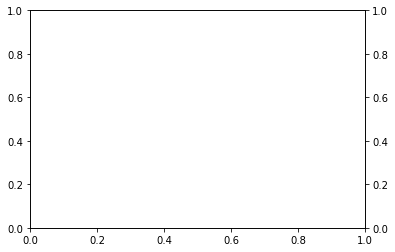

In [260]:
plot_mdrun(lmp_i)

Cool the volume is decreasing 

In [261]:
lmp_i.store()

In [262]:
lmp_i.pull()

Read in data file output and update positions

In [264]:
datafn = lmp_i.files['output']['data_3']
print datafn

equ0.data


In [265]:
lmp_i.read_data_pos(datafn)

In [266]:
print lmp_i.strucC.lat.matrix

[[ 65.28540329   0.           0.        ]
 [  0.          65.28540329   0.        ]
 [  0.           0.          65.28540329]]


In [267]:
lmp_i.strucC.tag += '_equ0'

In [268]:
lmp_i.strucC.write_xyz()

In [269]:
lmp_i.strucC.calc_center_mass()

In [270]:
struc_i = lmp_i.strucC

In [271]:
struc_json = struc_i.export_json()

Let us create a new project to hold all the ET calculations we need to do for each pair of groups

In [272]:
mol_et_equ0 = streamm.Project('mol_et_equ0')

In [273]:
mol_et_equ0.set_resource(res_local)

In [274]:
os.chdir(mol_et_equ0.dir['materials'])

If we need to restart the project here all we have to do is load in the structure 

In [275]:
try:
    print  struc_i
except:
    struc_i = streamm.Buildingblock('p3HTx50_equ0')
    struc_i.import_json()

 p3HTx50_equ0


In [276]:
struc_i.write_xyz('t1.xyz')

Create groups out of the molecules

In [277]:
groupset_i = streamm.Groups('mol',struc_i)

In [278]:
groupset_i.group_prop('mol','oligomers')

In [279]:
print len(groupset_i.groups)

50


In [280]:
groupset_i.strucC.lat.pbcs = [True,True,True]

In [281]:
print groupset_i.strucC.lat.pbcs

[True, True, True]


In [282]:
print groupset_i.strucC.lat.matrix

[[ 65.28540329   0.           0.        ]
 [  0.          65.28540329   0.        ]
 [  0.           0.          65.28540329]]


Apply periodic boundries to all the groups, so the molecules are not split across pbc's

In [283]:
groupset_i.group_pbcs()

In [284]:
groupset_i.strucC.write_xyz('groups.xyz')

In [285]:
groupset_i.calc_cent_mass()
groupset_i.calc_radius()
# groupset_i.calc_dl()

In [286]:
print groupset_i.strucC.lat
print len(groupset_i.cent_mass)
print len(groupset_i.radius)

65.285403 0.000000 0.000000
0.000000 65.285403 0.000000
0.000000 0.000000 65.285403
50
50


Save the structure we are creating our pairs from 

In [287]:
gmol_json = groupset_i.strucC.export_json()

Create a neighbor list of groups 

In [288]:
groupset_i.group_nblist.radii_nblist(groupset_i.strucC.lat,groupset_i.cent_mass,groupset_i.radius,radii_buffer=0.500)

In [289]:
print groupset_i.group_nblist

 NBlist of 50 particle with 162 connections


In [290]:
g_nbs = []
for gk_i,g_i in groupset_i.groups.iteritems():
        n_nbs = groupset_i.group_nblist.calc_nnab(gk_i)
        g_nbs.append(n_nbs)
g_nbs = np.array(g_nbs)    

In [291]:
print g_nbs.min(),g_nbs.mean(),g_nbs.max()

0 3.24 7


Loop over each group, shift the group to the center of the simulation cell and write an .xyz file that includes the neighbors of the group.

In [292]:
for gk_i,g_i in groupset_i.groups.iteritems():
        list_i = copy.deepcopy(g_i.pkeys)
        for g_j in groupset_i.group_nblist.getnbs(gk_i):
            list_i += groupset_i.groups[g_j].pkeys
        print gk_i,groupset_i.group_nblist.calc_nnab(gk_i),len(list_i)
        groupset_i.strucC.shift_pos(-1.0*g_i.cent_mass)  # Place center of mass at origin
        groupset_i.strucC.write_xyz_list(list_i,xyz_file='nn_{}.xyz'.format(gk_i))
        groupset_i.strucC.shift_pos(g_i.cent_mass)  # Return center of mass 
        
        list_i = []
        

0 2 381
1 4 635
2 2 381
3 1 254
4 0 127
5 5 762
6 4 635
7 2 381
8 5 762
9 3 508
10 1 254
11 4 635
12 1 254
13 2 381
14 3 508
15 3 508
16 2 381
17 0 127
18 4 635
19 2 381
20 2 381
21 4 635
22 3 508
23 3 508
24 0 127
25 6 889
26 3 508
27 2 381
28 2 381
29 5 762
30 5 762
31 7 1016
32 6 889
33 3 508
34 6 889
35 4 635
36 4 635
37 4 635
38 5 762
39 4 635
40 1 254
41 4 635
42 5 762
43 4 635
44 2 381
45 3 508
46 1 254
47 5 762
48 4 635
49 5 762


The nearest neighbor cluster look good so let us calculate the electron transfer 

Firts create a list of unique pairs 

In [293]:
et_pairs = {}
et_pairs['i'] = []
et_pairs['j'] = []
for gk_i,g_i in groupset_i.groups.iteritems():
    for gk_j in groupset_i.group_nblist.getnbs(gk_i):
        if( gk_j > gk_i ):
            et_pairs['i'].append(gk_i)
            et_pairs['j'].append(gk_j)
            
            

Convert the dictionary to a pandas Dataframe

In [295]:
import pandas as pd

In [296]:
et_df = pd.DataFrame(et_pairs)

In [297]:
et_df.columns

Index([u'i', u'j'], dtype='object')

Save that in a local file 

In [298]:
et_df.to_csv('et_pairs.csv',sep=',')

In [299]:
et_fn = 'et_pairs.csv'
try:
    print  len(et_df)
except:
    et_df = pd.read_csv(et_fn)

81


In [300]:
def nw_et(project_i,res_i,groupset_i,gk_i,gk_j,run_calc = True):

    calc_n =  len(project_i.calculations)     
    nwchem_et = streamm.NWChem('nw_et_{}_g{}_g{}'.format(project_i.tag,gk_i,gk_j))
    print(nwchem_et.tag)

    # Set calculation to run on external resource
    nwchem_et.set_resource(res_i)

    # Make the local directories 
    nwchem_et.make_dir()
    # Change to the `launch` directory
    os.chdir(nwchem_et.dir['launch'])

    group_i = groupset_i.groups[gk_i]
    group_j = groupset_i.groups[gk_j]    

    nwchem_et.properties['coord_i'] = group_i.write_coord()
    nwchem_et.properties['coord_j'] = group_j.write_coord()    
    nwchem_et.properties['coord_ij'] = nwchem_et.properties['coord_i'] + nwchem_et.properties['coord_j'] 
    
    

    nwchem_et.cp_file('templates','run',"nwchem_remote.pbs",'templates','launch')
    nwchem_et.cp_file('templates','nw',"nwchem_et.nw",'templates','launch')
    #
    nwchem_et.load_str('templates','nw')        
    nwchem_et.load_str('templates','run')
    # 
    nwchem_et.replacewrite_prop('nw','input','nw','%s.nw'%(nwchem_et.tag))

    nwchem_et.properties['input_nw'] = nwchem_et.files['input']['nw']
    nwchem_et.replacewrite_prop('run','scripts','run','%s.pbs'%(nwchem_et.tag))

    nwchem_et.add_file('output','log',"%s.log"%(nwchem_et.tag))
    # Save details in .json files 
    # 
    os.chdir(nwchem_et.dir['home'])
    nwchem_et.export_json()
    # 
    #
    if( run_calc ):
        os.chdir(nwchem_et.dir['launch'])
        nwchem_et.push()
        nwchem_et.run()
        
    return nwchem_et


Loop over all the pairs and create NWChem ET input files

In [301]:
et_df['calc_id'] = None

In [304]:
for k,pair_i in et_df.iterrows():
    gk_i = pair_i['i']
    gk_j = pair_i['j']
    nwchem_et = nw_et(mol_et_equ0,res_calc,groupset_i,gk_i,gk_j)
    et_df['calc_id'] = nwchem_et.tag 
    # Add calculation to project
    mol_et_equ0.add_calc(nwchem_et,deepcopy = True)    

nw_et_mol_et_equ0_g0_g42


IOError: [Errno 2] No such file or directory: u'/Users/tkemper/Development/streamm-tools/examples/../templates/nwchem_ssh.pbs'

In [ ]:
et_df.head()

In [ ]:
os.chdir(mol_et_equ0.dir['home'])
et_json = mol_et_equ0.export_json()

Now we have to wait for all of these calculations to finish

In [ ]:
import sys 

In [ ]:
calcsrunning = True 
while( calcsrunning ):
    calcsrunning = False 
    n_running = 0 
    for k,calc_i in mol_et_equ0.calculations.iteritems():
        calc_i.check()
        if( calc_i.meta['status'] == 'finished' ):
            n_running += 1
        else:
            calcsrunning = True 
    sys.stdout.write("progress: {}/{} \r".format(n_running,len(mol_et_equ0.calculations)))
    sys.stdout.flush()

    time.sleep(status_refresh)

Run analysis on the results 

In [ ]:
et_df['S_ij'] = None
et_df['S_ji'] = None
et_df['V_ij'] = None
et_df['V_ji'] = None

In [ ]:
for k,calc_i in mol_et_equ0.calculations.iteritems():
    calc_i.meta['status'] = 'written'


In [ ]:
for k,calc_i in mol_et_equ0.calculations.iteritems():
    calc_i.check()
    if(  calc_i.meta['status'] == 'finished' ):

        print calc_i.tag,calc_i.meta['status'] 
        os.chdir(calc_i.dir['launch'])

        et_row = et_df.loc[ et_df['calc_id'] == calc_i.tag ]
        et_index =  int(et_row.index[0])

        calc_i.analysis()

        if( len(calc_i.et_list) > 0  ):
            et_df.loc[et_index,'S_ij'] = calc_i.et_list[0].S
            et_df.loc[et_index,'V_ij'] = calc_i.et_list[0].V
            et_df.loc[et_index,'S_ji'] = calc_i.et_list[1].S
            et_df.loc[et_index,'V_ji'] = calc_i.et_list[1].V


        calc_i.store()


In [ ]:
et_df

In [ ]:
et_c1 = et_df.replace([np.inf], np.nan)

In [ ]:
et_c1.dropna()

In [ ]:
print et_c1['V_ij'].min(),et_c1['V_ij'].mean(),et_c1['V_ij'].max()

We can take a look at the histogram of magnitudes of V_ij

In [ ]:
et_c1['log_V_ij'] = np.log10(et_c1['V_ij'])

In [ ]:
et_c1['log_V_ij'].plot.hist(bins=30,alpha=1.0)

Just calculated the inter-molecular electronic coupling between P3ht

Boom!